# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка данных

In [ ]:
!pip install lightgbm
!pip install catboost
!pip install tqdm

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import xgboost as xgb

from catboost import CatBoostRegressor, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from tqdm import tqdm

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

## Подготовка данных

### Обработка пропущенных значений. Типы данных

#### Типы данных

Приведем данные в колонках `DateCrawled`, `RegistrationYear`, `DateCreated`, `LastSeen` к нужнему типу:

In [ ]:
df['RegistrationYear'] = df['RegistrationYear'].astype('int')
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

Колонка `DateCreated` не нужна, так как она дублируют колонку `DataCrawled`, удалим ее:

In [ ]:
df[['DateCrawled', 'DateCreated']].sample(5)

,DateCrawled,DateCreated
259395,2016-03-25 17:54:40,2016-03-25
280639,2016-03-10 00:58:22,2016-03-09
52008,2016-03-10 07:53:29,2016-03-10
148198,2016-04-03 21:50:54,2016-04-03
224676,2016-03-28 22:00:16,2016-03-28


In [ ]:
df = df.drop(columns=['DateCreated'])

Проведем обработку данных с датой и создадим новые колонки, при этом удалим саму колонку с датой:

In [ ]:
df[f"DateCrawled_year"] = df['DateCrawled'].dt.year
df[f"DateCrawled_month"] = df['DateCrawled'].dt.month
df[f"DateCrawled_day"] = df['DateCrawled'].dt.day    
df[f"DateCrawled_weekday"] = df['DateCrawled'].dt.weekday
df[f"DateCrawled_hour"] = df['DateCrawled'].dt.hour
df[f"DateCrawled_minute"] = df['DateCrawled'].dt.minute

In [ ]:
df[f"DateCrawled_year"].value_counts()

2016    354369
Name: DateCrawled_year, dtype: int64

Удалим колонку с годом, а  также колонку:

In [ ]:
df = df.drop(columns=['DateCrawled'])
df = df.drop(columns=['DateCrawled_year'])

In [ ]:
df[f"LastSeen_year"] = df['LastSeen'].dt.year
df[f"LastSeen_month"] = df['LastSeen'].dt.month
df[f"LastSeen_day"] = df['LastSeen'].dt.day    
df[f"LastSeen_weekday"] = df['LastSeen'].dt.weekday
df[f"LastSeen_hour"] = df['LastSeen'].dt.hour
df[f"LastSeen_minute"] = df['LastSeen'].dt.minute

In [ ]:
df[f"LastSeen_year"].value_counts()

2016    354369
Name: LastSeen_year, dtype: int64

Удалим колонки:

In [ ]:
df = df.drop(columns=['LastSeen'])
df = df.drop(columns=['LastSeen_year'])

Колонка `PostalCode` является категориальной, но для упращения моделирования, оставим только первые цифры почтового кода:

In [ ]:
df['PostalCode'] = round(df['PostalCode'] / 1000)
df = df.rename(columns={'PostalCode':'RegionCode'})
df['RegionCode'] = df['RegionCode'].astype('object')

#### Обработка пропущенных значений

Посмотрим на пропущенные значения в колонках: 

In [ ]:
df.isna().mean().sort_values(ascending=False).head(6)

NotRepaired    0.200791
VehicleType    0.105794
FuelType       0.092827
Gearbox        0.055967
Model          0.055606
Price          0.000000
dtype: float64

In [ ]:
df['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

In [ ]:
df['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [ ]:
df['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [ ]:
df['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

In [ ]:
df['Model'].value_counts(dropna=False)

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

Поскольку все данные в колонках пропущенных категориальные, и количество пропусков большое, заменим все NaN на "unknown"

In [ ]:
df = df.fillna('unknown')

In [ ]:
df.isna().sum()

Price                  0
VehicleType            0
RegistrationYear       0
Gearbox                0
Power                  0
Model                  0
Kilometer              0
RegistrationMonth      0
FuelType               0
Brand                  0
NotRepaired            0
NumberOfPictures       0
RegionCode             0
DateCrawled_month      0
DateCrawled_day        0
DateCrawled_weekday    0
DateCrawled_hour       0
DateCrawled_minute     0
LastSeen_month         0
LastSeen_day           0
LastSeen_weekday       0
LastSeen_hour          0
LastSeen_minute        0
dtype: int64

### Анализ данных

#### Числовые признаки

Посмотрим на числовые данные:

In [ ]:
num_columns = list(df.select_dtypes(exclude=['object']).columns)

In [ ]:
df[num_columns].sample(5)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,RegionCode,DateCrawled_month,DateCrawled_day,DateCrawled_weekday,DateCrawled_hour,DateCrawled_minute,LastSeen_month,LastSeen_day,LastSeen_weekday,LastSeen_hour,LastSeen_minute
244390,1499,2003,0,150000,12,0,52.0,3,30,2,16,55,4,7,3,7,45
308552,690,1996,54,125000,10,0,94.0,3,9,2,21,0,3,26,5,9,15
55755,2000,1996,0,150000,0,0,75.0,3,21,0,21,49,3,28,0,19,46
285035,8450,2007,150,150000,7,0,65.0,3,9,2,19,25,4,5,1,14,17
139742,600,1994,0,150000,6,0,43.0,3,18,4,17,42,3,21,0,7,17


Обработаем признаки, которые были изночально в датасете:

Цена, наше целевая переменная:

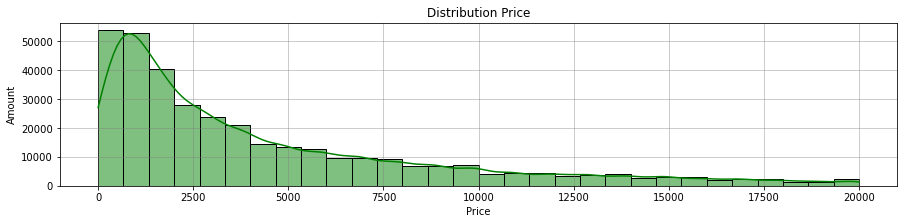

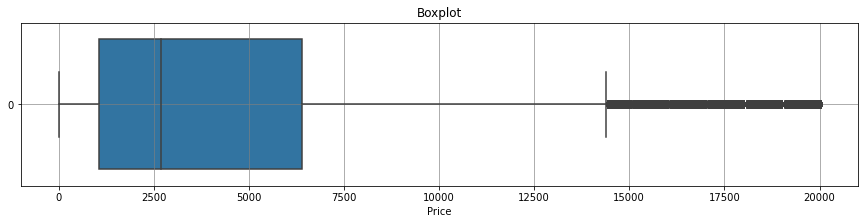

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='Price', kde=True, bins=30, color='green')

plt.title(f'Distribution Price')
plt.ylabel('Amount')
plt.xlabel('Price')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['Price'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Price')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Имеются выбросы в высокой цене, плюс цены ниже ~ 500, удалять их не будем, так как это могут быть в высоких ценах премиум машину, а в низких машины для "рыбалки"

Год регистрации автомобиля:

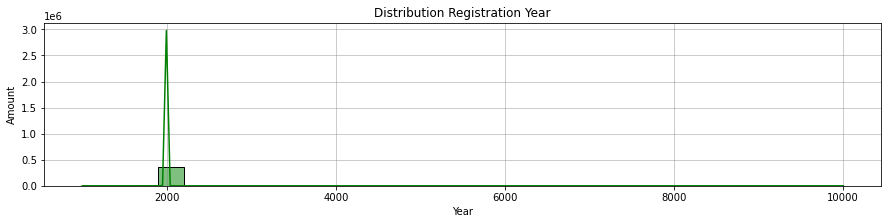

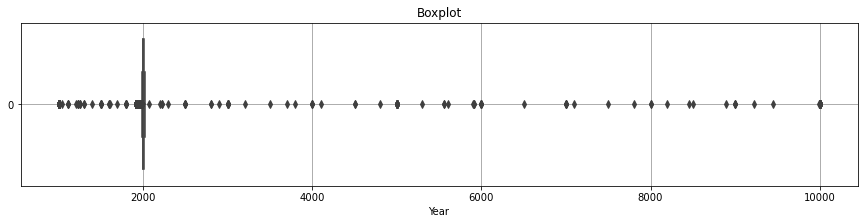

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='RegistrationYear', kde=True, bins=30, color='green')

plt.title(f'Distribution Registration Year')
plt.ylabel('Amount')
plt.xlabel('Year')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['RegistrationYear'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Year')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Имеются выборсы, оценим их предположив, что автомобили старше 1970 и младше 2016, это ошибки в данных.

Посмотрим, сколько у нас не верных данных по годам:

In [ ]:
(len(df) - len(df['RegistrationYear'][(df['RegistrationYear'] >= 1970) & (df['RegistrationYear'] <= 2016)])) / len(df)

0.04477818319322514

Перезапишем датасет:

In [ ]:
df = df[(df['RegistrationYear'] >= 1970) & (df['RegistrationYear'] <= 2016)]

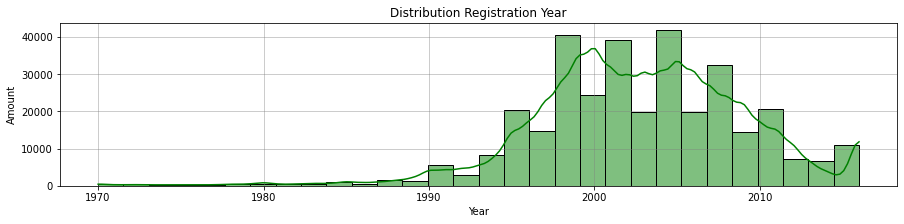

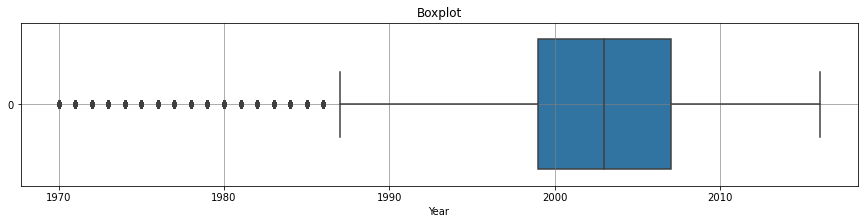

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='RegistrationYear', kde=True, bins=30, color='green')

plt.title(f'Distribution Registration Year')
plt.ylabel('Amount')
plt.xlabel('Year')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['RegistrationYear'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Year')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Данные в порядке.

Месяц регистрации автомобиля

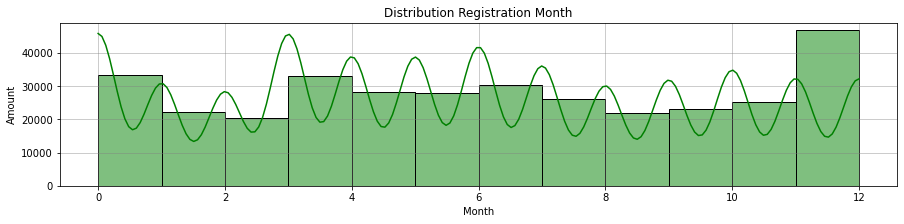

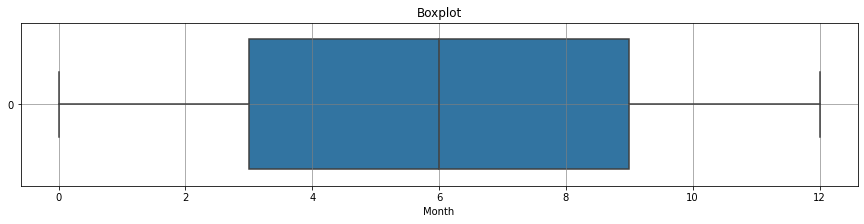

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='RegistrationMonth', kde=True, bins=12, color='green')

plt.title(f'Distribution Registration Month')
plt.ylabel('Amount')
plt.xlabel('Month')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['RegistrationMonth'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Month')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Выбросов нет, данные хорошие по месяцу

Посмотрим на мощность:

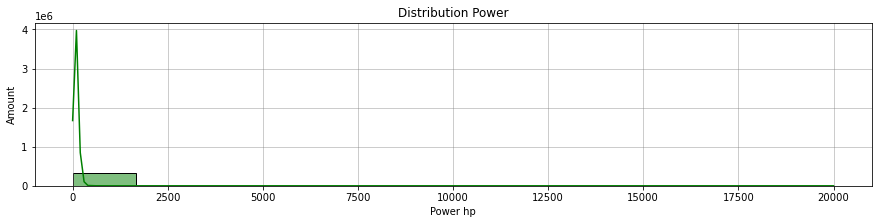

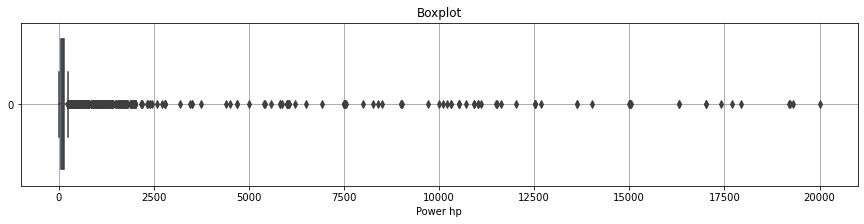

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='Power', kde=True, bins=12, color='green')

plt.title(f'Distribution Power')
plt.ylabel('Amount')
plt.xlabel('Power hp')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['Power'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Power hp')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Поизучав сайты по продажам авто (avto.ru, avito.ru и wikipedia), максимальная мощность двигателя ~ 1500 л. с. (The new Bugatti Chiron: 1479 horsepower, 261mph, $2.6 million) (мы ведь не торгуем самосвалами с двигателями 3500).
Будем считать данные больше 1500, ошибками:

In [ ]:
(len(df) - len(df['Power'][(df['Power'] <= 1500)])) / len(df)

0.0005465271889891019

менее 1 % выбросов, чистим их:

In [ ]:
df = df[df['Power'] <= 1500]

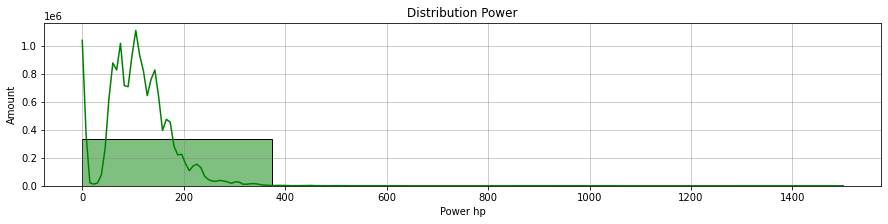

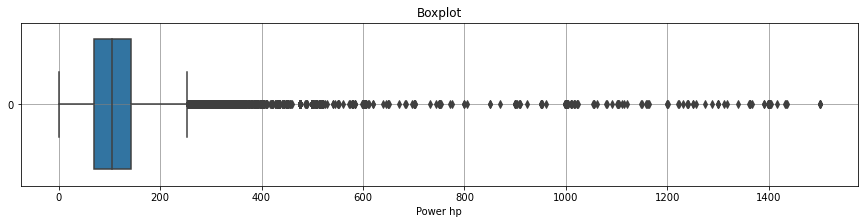

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='Power', kde=True, bins=4, color='green')

plt.title(f'Distribution Power')
plt.ylabel('Amount')
plt.xlabel('Power hp')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['Power'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Power hp')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Стало лучше, но все равно выбросы остались, но машины с мощным двигателям стоят много дороже, чем рядовые, поэтому данные с ценой и мощностью выглядят логичными.

Посмотрим на пробег:

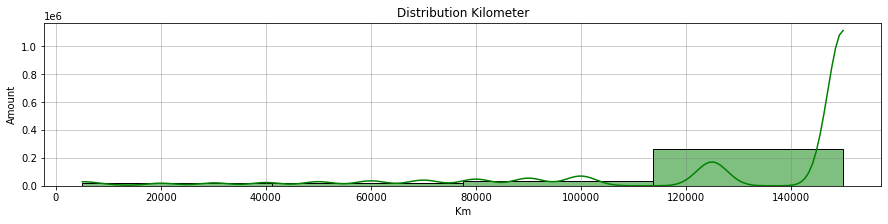

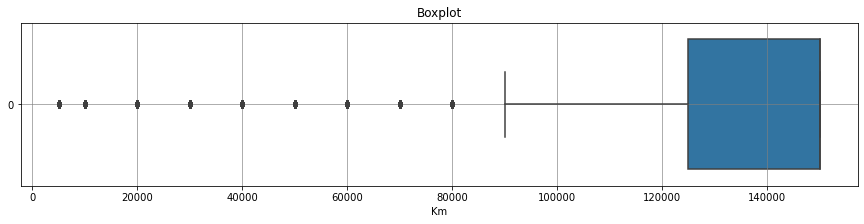

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df, x='Kilometer', kde=True, bins=4, color='green')

plt.title(f'Distribution Kilometer')
plt.ylabel('Amount')
plt.xlabel('Km')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df['Kilometer'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Km')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Имеются выбросы с менее 80000, это могут быть новые авто, оствим здесь все не тронутым.

In [ ]:
df['NumberOfPictures'].value_counts()

0    338316
Name: NumberOfPictures, dtype: int64

Одни нули (интересно почему?, продать авто с фото гораздо проще, явно ошибка при выгрузке файлов), после матрицы корреляции, удалим.

Посмотрим на корреляцию в данных:

Text(0.5, 1.0, 'Correlation Heatmap')

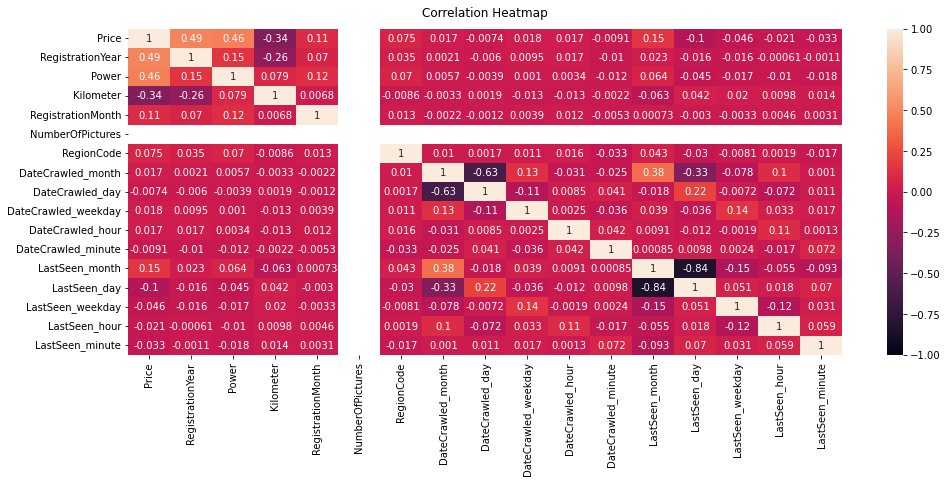

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[num_columns].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Видим высокие корреляции у столбцов `DateCrawled_month` и `DateCrawled_day`, `LastSeen_month` и `LastSeen_day`, удалим один из столбцов:

In [ ]:
df = df.drop(columns=['DateCrawled_month'])
df = df.drop(columns=['LastSeen_month'])

In [ ]:
df = df.drop(columns=['NumberOfPictures'])

#### Категориальные признаки

Посмотрим на категориальные данные:

In [ ]:
cat_columns = list(df.select_dtypes(include=['object']).columns)

In [ ]:
for i in range(len(cat_columns)):
    print(f"Название колонки: {cat_columns[i]}")
    print(df[cat_columns[i]].value_counts())
    print('___________________________________')

Название колонки: VehicleType
sedan          90969
small          79686
wagon          65073
bus            28727
unknown        22703
convertible    20078
coupe          15976
suv            11907
other           3197
Name: VehicleType, dtype: int64
___________________________________
Название колонки: Gearbox
manual     256683
auto        64081
unknown     17552
Name: Gearbox, dtype: int64
___________________________________
Название колонки: Model
golf                  27598
other                 23334
3er                   19215
unknown               17152
polo                  12440
                      ...  
serie_3                   4
serie_2                   4
rangerover                3
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64
___________________________________
Название колонки: FuelType
petrol      209010
gasoline     96219
unknown      26903
lpg           5153
cng            540
hybrid         223
other          180
el

Странных наименование не наблюдаем, при этом lada не очень популярная марка машины

### Разбиение данных на выборки

Выделим целевой признак и признаки для обучения:

In [ ]:
features = df.drop(columns=['Price'])
target = df['Price']

Запишем столбца с категориальными данными и остальными:

In [ ]:
cat_columns = list(features.select_dtypes(include=['object']).columns)

In [ ]:
num_columns = list(features.select_dtypes(exclude=['object']).columns)

Разобьем данные: 60% - train set, 20% - validation set, 20% - test set:

In [ ]:
features_train, features_not_encode, target_train, target_not_encode = train_test_split(features, target, test_size=.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_not_encode, target_not_encode, test_size=.5, random_state=42)

In [ ]:
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(202989, 19) (67663, 19) (67664, 19)
(202989,) (67663,) (67664,)


In [ ]:
features_train.sample(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,RegionCode,DateCrawled_day,DateCrawled_weekday,DateCrawled_hour,DateCrawled_minute,LastSeen_day,LastSeen_weekday,LastSeen_hour,LastSeen_minute
46350,sedan,2007,manual,95,one,90000,5,petrol,mini,unknown,47.0,31,3,20,57,31,3,20,57
149076,sedan,2006,auto,387,s_klasse,150000,1,petrol,mercedes_benz,no,46.0,16,2,21,58,5,1,12,19
78970,small,1997,manual,60,micra,150000,6,petrol,nissan,no,49.0,30,2,12,51,7,3,3,44
98686,small,2008,manual,80,fiesta,100000,4,petrol,ford,yes,52.0,10,3,23,57,12,5,10,48
259743,small,2013,manual,77,i_reihe,20000,8,petrol,hyundai,no,93.0,14,0,21,37,30,2,0,18


### Масштабирование числовых признаков

Создадим копии данных для обучения и валидации (для моделей, для которых нужны только числовые признаки):

In [ ]:
features_encode = features

In [ ]:
numeric = num_columns
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_encode[numeric])
features_encode[numeric] = scaler.transform(features_encode[numeric])

OHE применять не будем, посольку слишком долго происходят обучение моделей.

Приведем категориальные признаки в номинальные с помощью LabelEncoder

In [ ]:
label_encode = LabelEncoder()
for column in cat_columns:
    label_encode.fit(features_encode[column].astype('str'))
    features_encode[column] = label_encode.transform(features_encode[column].astype('str'))

Разобьем данные: 60% - train set, 20% - validation set, 20% - test set:

In [ ]:
features_train_encode, features_encode, target_train_encode, target_encode = train_test_split(features_encode, target, test_size=.4, random_state=42)
features_valid_encode, features_test_encode, target_valid_encode, target_test_encode = train_test_split(features_encode, target_encode, test_size=.5, random_state=42)

In [ ]:
print(features_train_encode.shape, features_valid_encode.shape, features_test_encode.shape)
print(target_train_encode.shape, target_valid_encode.shape, target_test_encode.shape)

(202989, 19) (67663, 19) (67664, 19)
(202989,) (67663,) (67664,)


In [ ]:
features_train_encode.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,RegionCode,DateCrawled_day,DateCrawled_weekday,DateCrawled_hour,DateCrawled_minute,LastSeen_day,LastSeen_weekday,LastSeen_hour,LastSeen_minute
62818,4,0.517775,1,2.138894,116,-1.016018,1.142902,6,38,0,-0.914828,0.456100,1.501263,0.382736,0.350685,1.247267,-0.320397,-1.505879,1.003123
164593,4,-0.719756,1,-1.631242,228,0.576273,-1.554387,7,24,0,-0.682159,-1.627888,0.538564,1.305923,0.441226,-0.781121,-0.929645,1.408757,0.798998
81237,5,-0.410374,1,-0.877215,143,0.576273,0.603444,6,38,2,0.868963,0.346416,1.019913,-0.355814,0.893927,0.909202,2.116593,0.488345,0.935081
315347,8,-0.719756,1,0.932450,15,0.576273,-1.284658,6,2,1,-0.527047,-1.298837,-1.386834,1.305923,0.712846,-0.555744,0.288850,-1.659281,0.867040
129010,5,-0.100991,1,-0.500201,75,0.576273,1.142902,6,27,2,-0.798493,0.894834,0.057214,-0.355814,0.984467,1.698020,2.116593,-0.278664,0.730956


## Обучение моделей

### Random forest regressor

Подберем лучшие параметры:

In [ ]:
%%time

start = time.time()

rfr = RandomForestRegressor(random_state=42)
params = {'n_estimators': [50, 100],
          'max_depth': [2, 3],
          'min_samples_leaf' : [2, 3]}

cv_rfr_model = GridSearchCV(estimator=rfr, param_grid=params, n_jobs=-1, cv=5)
cv_rfr_model.fit(features_train_encode, target_train_encode)

end = time.time()
rfr_search_time = end - start

Wall time: 4min


In [ ]:
cv_rfr_model.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 100}

Обучим модель случайного леса с подобранными гиперпараметрами:

In [ ]:
%%time

start = time.time()

rfr_best_model = RandomForestRegressor(max_depth=3, min_samples_leaf=2, n_estimators=100, random_state=42)
rfr_best_model.fit(features_train_encode, target_train_encode)

end = time.time()
rfr_fit_time = end - start

Wall time: 16.5 s


In [ ]:
rfr_predict = rfr_best_model.predict(features_valid_encode)

In [ ]:
rfr_rsme = mean_squared_error(target_valid_encode, rfr_predict) ** 0.5

### Linear Regression

Обучим линейную регрессию:

In [ ]:
%%time
start = time.time()

lr_model = LinearRegression()
lr_model.fit(features_train_encode, target_train_encode)

end = time.time()
lr_fit_time = end - start

Wall time: 155 ms


In [ ]:
lr_predict = lr_model.predict(features_valid_encode)

In [ ]:
lr_rsme = mean_squared_error(target_valid_encode, lr_predict) ** 0.5

### Extreme gradient boosting regressor

Обучим модель экстримального градиентного бустинга:

In [ ]:
%%time
start = time.time()

xgbr = xgb.XGBRegressor(verbosity=0, random_state=42)

params = {'n_estimators': [50, 100],
          'objective' : ['reg:squarederror'],
          'learning_rate' : [0.1, 0.3],
          'max_depth': [2, 3]}

xgbr_model = GridSearchCV(estimator=xgbr, param_grid=params, n_jobs=-1, cv=5)

xgbr_model.fit(features_train_encode, target_train_encode)

end = time.time()
xgbr_search_time = end - start

Wall time: 47.4 s


In [ ]:
xgbr_model.best_params_

{'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 100,
 'objective': 'reg:squarederror'}

In [ ]:
%%time

start = time.time()

xgbr_best_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', learning_rate=0.3, max_depth=3)
xgbr_best_model.fit(features_train_encode, target_train_encode)

end = time.time()
xgbr_fit_time = end - start

Wall time: 2.22 s


In [ ]:
xgbr_predict = xgbr_best_model.predict(features_valid_encode)

In [ ]:
xgbr_rsme = mean_squared_error(target_valid_encode, xgbr_predict) ** 0.5

### Light Gradient Boosting Machine

Обучим модель LGBM:

In [ ]:
%%time
start = time.time()

gbm = lgb.LGBMRegressor( random_state=42)

params = {'num_leaves': [50, 100, 150],
          'learning_rate' : [0.1, 0.3, 0.5],
          'n_estimators': [100, 250]}

gbm_model = GridSearchCV(estimator=gbm, param_grid=params, n_jobs=-1, cv=5)

gbm_model.fit(features_train_encode, target_train_encode)

end = time.time()
gbm_search_time = end - start

Wall time: 1min 58s


In [ ]:
gbm_model.best_params_

{'learning_rate': 0.1, 'n_estimators': 250, 'num_leaves': 150}

In [ ]:
%%time
start = time.time()

gbm = lgb.LGBMRegressor(num_leaves=150, learning_rate=0.1, n_estimators=250)
gbm.fit(features_train_encode, target_train_encode, 
        eval_set=[(features_valid_encode, target_valid_encode)], 
        eval_metric='rmse', 
        callbacks=[lgb.early_stopping(5)])

end = time.time()
gbm_fit_time = end - start

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[215]	valid_0's rmse: 1644.93	valid_0's l2: 2.70579e+06
Wall time: 1.9 s


In [ ]:
gbm_predict = gbm.predict(features_valid_encode, num_iteration=gbm.best_iteration_)

In [ ]:
gbm_rsme = mean_squared_error(target_valid_encode, gbm_predict) ** 0.5

### Cat Boost Regressor

Обучим Cat boost regressor:

In [ ]:
%%time
start = time.time()

CBR = CatBoostRegressor()

parameters = {'max_depth' : [3, 5],
              'learning_rate' : [0.01, 0.05],
              'iterations' :  [100, 250],
              'eval_metric' : ['RMSE']}

Grid_CBR = GridSearchCV(estimator=CBR, param_grid=parameters, cv=5, n_jobs=-1)
Grid_CBR.fit(features_train, target_train, cat_features=cat_columns, eval_set=(features_valid, target_valid))

end = time.time()
cbr_search_time = end - start

0:	learn: 4393.4659958	test: 4409.5917431	best: 4409.5917431 (0)	total: 280ms	remaining: 1m 9s
1:	learn: 4264.2839001	test: 4279.6231380	best: 4279.6231380 (1)	total: 377ms	remaining: 46.8s
2:	learn: 4142.3102828	test: 4157.0700031	best: 4157.0700031 (2)	total: 439ms	remaining: 36.1s
3:	learn: 4025.3513008	test: 4038.9768020	best: 4038.9768020 (3)	total: 526ms	remaining: 32.3s
4:	learn: 3914.6259079	test: 3927.8673969	best: 3927.8673969 (4)	total: 635ms	remaining: 31.1s
5:	learn: 3814.1771404	test: 3826.3558963	best: 3826.3558963 (5)	total: 729ms	remaining: 29.6s
6:	learn: 3713.6849728	test: 3725.0509683	best: 3725.0509683 (6)	total: 824ms	remaining: 28.6s
7:	learn: 3621.6154697	test: 3631.9751292	best: 3631.9751292 (7)	total: 913ms	remaining: 27.6s
8:	learn: 3537.9382041	test: 3547.7239704	best: 3547.7239704 (8)	total: 1s	remaining: 26.8s
9:	learn: 3454.1645180	test: 3463.6828067	best: 3463.6828067 (9)	total: 1.09s	remaining: 26.3s
10:	learn: 3378.3773252	test: 3386.9087281	best: 3386

86:	learn: 2004.9253400	test: 1994.2034961	best: 1994.2034961 (86)	total: 7.96s	remaining: 14.9s
87:	learn: 2002.5136805	test: 1991.7983673	best: 1991.7983673 (87)	total: 8.06s	remaining: 14.8s
88:	learn: 1999.8188264	test: 1989.0830504	best: 1989.0830504 (88)	total: 8.13s	remaining: 14.7s
89:	learn: 1997.3524331	test: 1986.5077377	best: 1986.5077377 (89)	total: 8.23s	remaining: 14.6s
90:	learn: 1994.5347542	test: 1983.9842245	best: 1983.9842245 (90)	total: 8.33s	remaining: 14.6s
91:	learn: 1991.9094012	test: 1981.3785656	best: 1981.3785656 (91)	total: 8.41s	remaining: 14.5s
92:	learn: 1989.0968700	test: 1978.6469217	best: 1978.6469217 (92)	total: 8.49s	remaining: 14.3s
93:	learn: 1986.8256789	test: 1976.4093736	best: 1976.4093736 (93)	total: 8.61s	remaining: 14.3s
94:	learn: 1984.6721703	test: 1974.3449066	best: 1974.3449066 (94)	total: 8.69s	remaining: 14.2s
95:	learn: 1982.0818689	test: 1971.8671142	best: 1971.8671142 (95)	total: 8.8s	remaining: 14.1s
96:	learn: 1980.1813360	test: 1

171:	learn: 1891.1208189	test: 1884.9729938	best: 1884.9729938 (171)	total: 15.4s	remaining: 6.99s
172:	learn: 1890.4658123	test: 1884.2877439	best: 1884.2877439 (172)	total: 15.5s	remaining: 6.89s
173:	learn: 1889.6857248	test: 1883.5371251	best: 1883.5371251 (173)	total: 15.6s	remaining: 6.8s
174:	learn: 1888.6998197	test: 1882.6816115	best: 1882.6816115 (174)	total: 15.7s	remaining: 6.71s
175:	learn: 1887.9656740	test: 1882.0604156	best: 1882.0604156 (175)	total: 15.7s	remaining: 6.62s
176:	learn: 1886.7119919	test: 1880.9472275	best: 1880.9472275 (176)	total: 15.8s	remaining: 6.53s
177:	learn: 1885.6272272	test: 1880.1511272	best: 1880.1511272 (177)	total: 15.9s	remaining: 6.43s
178:	learn: 1884.8578940	test: 1879.5117396	best: 1879.5117396 (178)	total: 16s	remaining: 6.34s
179:	learn: 1883.9084868	test: 1878.6877266	best: 1878.6877266 (179)	total: 16.1s	remaining: 6.26s
180:	learn: 1882.7211224	test: 1877.5350961	best: 1877.5350961 (180)	total: 16.2s	remaining: 6.17s
181:	learn: 1

In [ ]:
Grid_CBR.best_params_

{'eval_metric': 'RMSE',
 'iterations': 250,
 'learning_rate': 0.05,
 'max_depth': 5}

In [ ]:
%%time
start = time.time()

cbr_best_model = CatBoostRegressor(eval_metric='RMSE', 
                                   iterations=250, learning_rate=0.05, 
                                   max_depth=5)

cbr_best_model.fit(features_train, target_train, cat_features=cat_columns, eval_set=(features_valid, target_valid))

end = time.time()
cbr_fit_time = end - start

0:	learn: 4393.4659958	test: 4409.5917431	best: 4409.5917431 (0)	total: 106ms	remaining: 26.3s
1:	learn: 4264.2839001	test: 4279.6231380	best: 4279.6231380 (1)	total: 197ms	remaining: 24.4s
2:	learn: 4142.3102828	test: 4157.0700031	best: 4157.0700031 (2)	total: 273ms	remaining: 22.5s
3:	learn: 4025.3513008	test: 4038.9768020	best: 4038.9768020 (3)	total: 365ms	remaining: 22.4s
4:	learn: 3914.6259079	test: 3927.8673969	best: 3927.8673969 (4)	total: 468ms	remaining: 22.9s
5:	learn: 3814.1771404	test: 3826.3558963	best: 3826.3558963 (5)	total: 570ms	remaining: 23.2s
6:	learn: 3713.6849728	test: 3725.0509683	best: 3725.0509683 (6)	total: 656ms	remaining: 22.8s
7:	learn: 3621.6154697	test: 3631.9751292	best: 3631.9751292 (7)	total: 752ms	remaining: 22.7s
8:	learn: 3537.9382041	test: 3547.7239704	best: 3547.7239704 (8)	total: 833ms	remaining: 22.3s
9:	learn: 3454.1645180	test: 3463.6828067	best: 3463.6828067 (9)	total: 938ms	remaining: 22.5s
10:	learn: 3378.3773252	test: 3386.9087281	best: 3

85:	learn: 2008.0934745	test: 1997.4399254	best: 1997.4399254 (85)	total: 7.98s	remaining: 15.2s
86:	learn: 2004.9253400	test: 1994.2034961	best: 1994.2034961 (86)	total: 8.06s	remaining: 15.1s
87:	learn: 2002.5136805	test: 1991.7983673	best: 1991.7983673 (87)	total: 8.16s	remaining: 15s
88:	learn: 1999.8188264	test: 1989.0830504	best: 1989.0830504 (88)	total: 8.26s	remaining: 14.9s
89:	learn: 1997.3524331	test: 1986.5077377	best: 1986.5077377 (89)	total: 8.37s	remaining: 14.9s
90:	learn: 1994.5347542	test: 1983.9842245	best: 1983.9842245 (90)	total: 8.47s	remaining: 14.8s
91:	learn: 1991.9094012	test: 1981.3785656	best: 1981.3785656 (91)	total: 8.58s	remaining: 14.7s
92:	learn: 1989.0968700	test: 1978.6469217	best: 1978.6469217 (92)	total: 8.7s	remaining: 14.7s
93:	learn: 1986.8256789	test: 1976.4093736	best: 1976.4093736 (93)	total: 8.82s	remaining: 14.6s
94:	learn: 1984.6721703	test: 1974.3449066	best: 1974.3449066 (94)	total: 8.9s	remaining: 14.5s
95:	learn: 1982.0818689	test: 1971

169:	learn: 1892.3721571	test: 1886.2301581	best: 1886.2301581 (169)	total: 15.6s	remaining: 7.35s
170:	learn: 1891.7100987	test: 1885.5979794	best: 1885.5979794 (170)	total: 15.7s	remaining: 7.26s
171:	learn: 1891.1208189	test: 1884.9729938	best: 1884.9729938 (171)	total: 15.8s	remaining: 7.17s
172:	learn: 1890.4658123	test: 1884.2877439	best: 1884.2877439 (172)	total: 15.9s	remaining: 7.07s
173:	learn: 1889.6857248	test: 1883.5371251	best: 1883.5371251 (173)	total: 16s	remaining: 6.98s
174:	learn: 1888.6998197	test: 1882.6816115	best: 1882.6816115 (174)	total: 16.1s	remaining: 6.88s
175:	learn: 1887.9656740	test: 1882.0604156	best: 1882.0604156 (175)	total: 16.2s	remaining: 6.79s
176:	learn: 1886.7119919	test: 1880.9472275	best: 1880.9472275 (176)	total: 16.2s	remaining: 6.7s
177:	learn: 1885.6272272	test: 1880.1511272	best: 1880.1511272 (177)	total: 16.3s	remaining: 6.6s
178:	learn: 1884.8578940	test: 1879.5117396	best: 1879.5117396 (178)	total: 16.4s	remaining: 6.51s
179:	learn: 18

In [ ]:
cbr_predict = cbr_best_model.predict(features_valid)

In [ ]:
cbr_rmse = mean_squared_error(target_valid, cbr_predict) ** 0.5

## Анализ моделей

Сделаем предсказания на тестовой выборке, рассчитаем RMSE для каждой модели, и построим сводную таблицу:

In [ ]:
# RandomForestRegressor
rfr_predict = rfr_best_model.predict(features_test_encode)
rfr_rsme_test = mean_squared_error(target_test_encode, rfr_predict) ** 0.5
# Linear Regression
lr_predict = lr_model.predict(features_test_encode)
lr_rsme_test = mean_squared_error(target_test_encode, lr_predict) ** 0.5
# Extreme gradien boosting regressor
xgbr_predict = xgbr_best_model.predict(features_test_encode)
xgbr_rsme_test = mean_squared_error(target_test_encode, xgbr_predict) ** 0.5
# light gradien boosting machine
gbm_predict = gbm.predict(features_test_encode)
gbm_rsme_test = mean_squared_error(target_test_encode, gbm_predict) ** 0.5
# Cat Boost regressor
cbr_predict = cbr_best_model.predict(features_test)
cbr_rmse_test = mean_squared_error(target_test, cbr_predict) ** 0.5

In [ ]:
model_results = {
                'RMSE score': [rfr_rsme_test, lr_rsme_test, xgbr_rsme_test, gbm_rsme_test, cbr_rmse_test],
                'RMSE valid score': [rfr_rsme, lr_rsme, xgbr_rsme, gbm_rsme, cbr_rmse],
                'Search time, sec': [rfr_search_time, np.NaN, xgbr_search_time, gbm_search_time, cbr_search_time],
                'Fit time, sec': [rfr_fit_time, lr_fit_time, xgbr_fit_time, gbm_fit_time, cbr_fit_time]
                 }

Посмотрим на результаты:

In [ ]:
results = pd.DataFrame(data=model_results, index=('Random Forest Regressor', 'Linear Regression', 'XGBoost', 'LightGBM', 'Catboost'))
results

,RMSE score,RMSE valid score,"Search time, sec","Fit time, sec"
Random Forest Regressor,3178.370532,3173.223521,240.025907,5.490235
Linear Regression,3090.955063,3073.702835,NaN,0.155413
XGBoost,1860.068067,1861.537845,47.442798,2.224445
LightGBM,1640.720315,1644.929330,118.638390,1.897468
Catboost,1842.814635,1837.849010,366.215635,23.097715


## Вывод

Лучшие результаты показали модели LightGBM, Catboost и XGBoost, при этом стоит отметить, что LightGBM и XGBoost работают быстрее, чем Catboost.  
В дальнейшем для улучшения результатов, стоит провести лучше поиск параметров, с целью экономинии времении сейчас этого сделано не было.